# Build a Bot Detector to detect Kaggle Bot Account

## Workflow:

## Goals:
Analyze and select the variables that siginificantly affect bot detection to build a predictive model to idetify users that are bots

In [35]:
# Importing the Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy import stats

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

In [2]:
# setting up default plotting parameters
%matplotlib inline

plt.rcParams['figure.figsize'] = [15.0, 12.0]
plt.rcParams.update({'font.size': 20,})

sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

## Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Loading the dataset.
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project to show/bot-detection/kaggle_bot_accounts.csv")
data = data.drop(data.columns[0], axis=1)
data.head()

,NAME,GENDER,EMAIL_ID,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,REGISTRATION_IPV4,REGISTRATION_LOCATION,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
0,Johnny KerrThomas,Male,jacksonalan@example.com,False,53.0,87.0,5.0,3.0,124.0,NaN,81.88.75.170,Argentina,16.0,10.0,3.0,NaN
1,Dwayne LarsenLara,Male,calvin80@example.com,True,16.0,67.0,5.0,NaN,26.0,24.97,NaN,New Zealand,14.0,5.0,2.0,NaN
2,NaN,Male,qbrown@example.net,True,44.0,81.0,4.0,17.0,125.0,7.75,159.202.103.178,Costa Rica,16.0,4.0,0.0,False
3,Russell SimmonsPhillips,Male,kimberlywagner@example.com,True,23.0,114.0,5.0,24.0,67.0,13.40,196.11.132.51,Italy,21.0,10.0,1.0,False
4,Jamie WilsonMartinez,Female,shaunbrooks@example.com,False,46.0,112.0,2.0,12.0,63.0,24.83,159.196.199.20,Belgium,10.0,6.0,2.0,False


## Data Preprocessing

In [5]:
# Check the variables
print(data.columns)

print("\nSize: ", data.shape)

Index(['NAME', 'GENDER', 'EMAIL_ID', 'IS_GLOGIN', 'FOLLOWER_COUNT',
       'FOLLOWING_COUNT', 'DATASET_COUNT', 'CODE_COUNT', 'DISCUSSION_COUNT',
       'AVG_NB_READ_TIME_MIN', 'REGISTRATION_IPV4', 'REGISTRATION_LOCATION',
       'TOTAL_VOTES_GAVE_NB', 'TOTAL_VOTES_GAVE_DS', 'TOTAL_VOTES_GAVE_DC',
       'ISBOT'],
      dtype='object')

Size:  (1321188, 16)


In [6]:
# Check the missing values
data.isnull().sum()

NAME                     78164
GENDER                   77879
EMAIL_ID                 77814
IS_GLOGIN                77916
FOLLOWER_COUNT           77712
FOLLOWING_COUNT          78445
DATASET_COUNT            78567
CODE_COUNT               77926
DISCUSSION_COUNT         77722
AVG_NB_READ_TIME_MIN     78316
REGISTRATION_IPV4        78329
REGISTRATION_LOCATION    78290
TOTAL_VOTES_GAVE_NB      77705
TOTAL_VOTES_GAVE_DS      77934
TOTAL_VOTES_GAVE_DC      78030
ISBOT                    78500
dtype: int64

In [7]:
# Displaying the missing percentage
missing_value = data.isnull().sum().sort_values(ascending = True)
percent = ((data.isnull().sum()/data.isnull().count()) * 100) .sort_values(ascending=True)
missing_data = pd.concat([missing_value, percent], axis = 1, keys = ["Values", "Percentage"])
missing_data

,Values,Percentage
TOTAL_VOTES_GAVE_NB,77705,5.881449
FOLLOWER_COUNT,77712,5.881979
DISCUSSION_COUNT,77722,5.882736
EMAIL_ID,77814,5.889699
GENDER,77879,5.894619
IS_GLOGIN,77916,5.897420
CODE_COUNT,77926,5.898176
TOTAL_VOTES_GAVE_DS,77934,5.898782
TOTAL_VOTES_GAVE_DC,78030,5.906048
NAME,78164,5.916191


In [8]:
# Define the columns by type
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
categorical_columns = data.select_dtypes(exclude=np.number).columns.tolist()

# Fill missing values for numerical columns with their mean
for column in numerical_columns:
    mean_value = round(data[column].mean())
    data[column].fillna(mean_value, inplace=True)

# Fill missing values for categorical columns with their mode
for column in categorical_columns:
    mode_value = data[column].mode()[0]
    data[column].fillna(mode_value, inplace=True)

In [9]:
data.isna().sum()

NAME                     0
GENDER                   0
EMAIL_ID                 0
IS_GLOGIN                0
FOLLOWER_COUNT           0
FOLLOWING_COUNT          0
DATASET_COUNT            0
CODE_COUNT               0
DISCUSSION_COUNT         0
AVG_NB_READ_TIME_MIN     0
REGISTRATION_IPV4        0
REGISTRATION_LOCATION    0
TOTAL_VOTES_GAVE_NB      0
TOTAL_VOTES_GAVE_DS      0
TOTAL_VOTES_GAVE_DC      0
ISBOT                    0
dtype: int64

In [10]:
data.shape

(1321188, 16)

In [11]:
# Getting some information about the columns.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321188 entries, 0 to 1321187
Data columns (total 16 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   NAME                   1321188 non-null  object 
 1   GENDER                 1321188 non-null  object 
 2   EMAIL_ID               1321188 non-null  object 
 3   IS_GLOGIN              1321188 non-null  bool   
 4   FOLLOWER_COUNT         1321188 non-null  float64
 5   FOLLOWING_COUNT        1321188 non-null  float64
 6   DATASET_COUNT          1321188 non-null  float64
 7   CODE_COUNT             1321188 non-null  float64
 8   DISCUSSION_COUNT       1321188 non-null  float64
 9   AVG_NB_READ_TIME_MIN   1321188 non-null  float64
 10  REGISTRATION_IPV4      1321188 non-null  object 
 11  REGISTRATION_LOCATION  1321188 non-null  object 
 12  TOTAL_VOTES_GAVE_NB    1321188 non-null  float64
 13  TOTAL_VOTES_GAVE_DS    1321188 non-null  float64
 14  TOTAL_VOTES_GAVE_D

In [12]:
# Dropping irrelevant columns
columns_to_drop = ["NAME", "EMAIL_ID", "REGISTRATION_IPV4", "REGISTRATION_LOCATION"]
data.drop(columns=columns_to_drop, axis=1, inplace=True)

In [13]:
data['IS_GLOGIN'] = data['IS_GLOGIN'].astype('object')

In [14]:
data

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
0,Male,False,53.0,87.0,5.0,3.0,124.0,13.00,16.0,10.0,3.0,False
1,Male,True,16.0,67.0,5.0,10.0,26.0,24.97,14.0,5.0,2.0,False
2,Male,True,44.0,81.0,4.0,17.0,125.0,7.75,16.0,4.0,0.0,False
3,Male,True,23.0,114.0,5.0,24.0,67.0,13.40,21.0,10.0,1.0,False
4,Female,False,46.0,112.0,2.0,12.0,63.0,24.83,10.0,6.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1321183,Female,False,1.0,3.0,0.0,1.0,9.0,0.26,25.0,10.0,2.0,True
1321184,Female,True,20.0,60.0,6.0,14.0,44.0,23.39,22.0,10.0,3.0,False
1321185,Male,True,20.0,64.0,3.0,24.0,67.0,9.49,24.0,7.0,0.0,False
1321186,Male,False,0.0,1.0,0.0,0.0,3.0,1.70,14.0,8.0,2.0,True


In [15]:
print("Percentage of fake accounts is {:.1f}% and non-fake accounts is: {:.1f}%".format(
    data[data['ISBOT'] == True].shape[0] / data.shape[0]*100,
    data[data['ISBOT'] == False].shape[0] / data.shape[0]*100))

Percentage of fake accounts is 25.2% and non-fake accounts is: 74.8%


> It can be observed from the above code that the dataset is inbalanced (skewed towards non fake accounts).

In [16]:
bot = data[data['ISBOT'] == True]
not_bot = data[data['ISBOT'] == False]
print(bot.shape, not_bot.shape)

(332894, 12) (988294, 12)


In [17]:
# Turn imbalance dataset into balanced dataset
not_bot_downsampled = resample(not_bot, replace=False, n_samples= 332894)
df = pd.concat([not_bot_downsampled, bot])

# Checking the balanced dataset.
df["ISBOT"].value_counts()

False    332894
True     332894
Name: ISBOT, dtype: int64

In [18]:
# Encode the target variable.
le = LabelEncoder()
df["ISBOT"] = le.fit_transform(df["ISBOT"])
df

,GENDER,IS_GLOGIN,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,ISBOT
754935,Male,False,58.0,86.0,3.0,16.0,85.0,9.49,10.0,4.0,2.0,0
589649,Female,True,40.0,85.0,2.0,9.0,81.0,6.15,17.0,5.0,2.0,0
491272,Male,False,49.0,103.0,3.0,9.0,44.0,8.18,18.0,3.0,0.0,0
279887,Male,True,68.0,117.0,0.0,22.0,85.0,14.96,12.0,7.0,0.0,0
553408,Male,True,18.0,76.0,3.0,12.0,78.0,7.31,11.0,8.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1321177,Female,False,2.0,3.0,0.0,1.0,3.0,0.80,23.0,9.0,3.0,1
1321179,Male,False,0.0,45.0,0.0,1.0,5.0,0.35,11.0,5.0,1.0,1
1321183,Female,False,1.0,3.0,0.0,1.0,9.0,0.26,25.0,10.0,2.0,1
1321186,Male,False,0.0,1.0,0.0,0.0,3.0,1.70,14.0,8.0,2.0,1


## Feature Extraction

In [19]:
target = df["ISBOT"]
features = df.drop("ISBOT", axis = 1)

In [20]:
target

754935     0
589649     0
491272     0
279887     0
553408     0
          ..
1321177    1
1321179    1
1321183    1
1321186    1
1321187    1
Name: ISBOT, Length: 665788, dtype: int64

In [21]:
# Performing one-hot encoding on the features
features = pd.get_dummies(features)
features

,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,GENDER_Female,GENDER_Male,IS_GLOGIN_False,IS_GLOGIN_True
754935,58.0,86.0,3.0,16.0,85.0,9.49,10.0,4.0,2.0,0,1,1,0
589649,40.0,85.0,2.0,9.0,81.0,6.15,17.0,5.0,2.0,1,0,0,1
491272,49.0,103.0,3.0,9.0,44.0,8.18,18.0,3.0,0.0,0,1,1,0
279887,68.0,117.0,0.0,22.0,85.0,14.96,12.0,7.0,0.0,0,1,0,1
553408,18.0,76.0,3.0,12.0,78.0,7.31,11.0,8.0,1.0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1321177,2.0,3.0,0.0,1.0,3.0,0.80,23.0,9.0,3.0,1,0,1,0
1321179,0.0,45.0,0.0,1.0,5.0,0.35,11.0,5.0,1.0,0,1,1,0
1321183,1.0,3.0,0.0,1.0,9.0,0.26,25.0,10.0,2.0,1,0,1,0
1321186,0.0,1.0,0.0,0.0,3.0,1.70,14.0,8.0,2.0,0,1,1,0


In [22]:
# Normalizing the features
scaler = MinMaxScaler()
norm_features = scaler.fit_transform(features)
features = pd.DataFrame(norm_features, columns = features.columns)

In [23]:
features

,FOLLOWER_COUNT,FOLLOWING_COUNT,DATASET_COUNT,CODE_COUNT,DISCUSSION_COUNT,AVG_NB_READ_TIME_MIN,TOTAL_VOTES_GAVE_NB,TOTAL_VOTES_GAVE_DS,TOTAL_VOTES_GAVE_DC,GENDER_Female,GENDER_Male,IS_GLOGIN_False,IS_GLOGIN_True
0,0.828571,0.716667,0.428571,0.64,0.566667,0.316439,0.000000,0.142857,0.666667,0.0,1.0,1.0,0.0
1,0.571429,0.708333,0.285714,0.36,0.540000,0.205068,0.466667,0.285714,0.666667,1.0,0.0,0.0,1.0
2,0.700000,0.858333,0.428571,0.36,0.293333,0.272758,0.533333,0.000000,0.000000,0.0,1.0,1.0,0.0
3,0.971429,0.975000,0.000000,0.88,0.566667,0.498833,0.133333,0.571429,0.000000,0.0,1.0,0.0,1.0
4,0.257143,0.633333,0.428571,0.48,0.520000,0.243748,0.066667,0.714286,0.333333,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
665783,0.028571,0.025000,0.000000,0.04,0.020000,0.026676,0.866667,0.857143,1.000000,1.0,0.0,1.0,0.0
665784,0.000000,0.375000,0.000000,0.04,0.033333,0.011671,0.066667,0.285714,0.333333,0.0,1.0,1.0,0.0
665785,0.014286,0.025000,0.000000,0.04,0.060000,0.008670,1.000000,1.000000,0.666667,1.0,0.0,1.0,0.0
665786,0.000000,0.008333,0.000000,0.00,0.020000,0.056686,0.266667,0.714286,0.666667,0.0,1.0,1.0,0.0


[1.73074011e-01 1.39304157e-01 8.77454125e-02 1.69887120e-01
 1.66424306e-01 1.42774911e-01 6.77702353e-03 4.19882451e-03
 2.07136277e-03 3.11606621e-05 3.18757556e-05 4.58828702e-02
 6.17969644e-02]


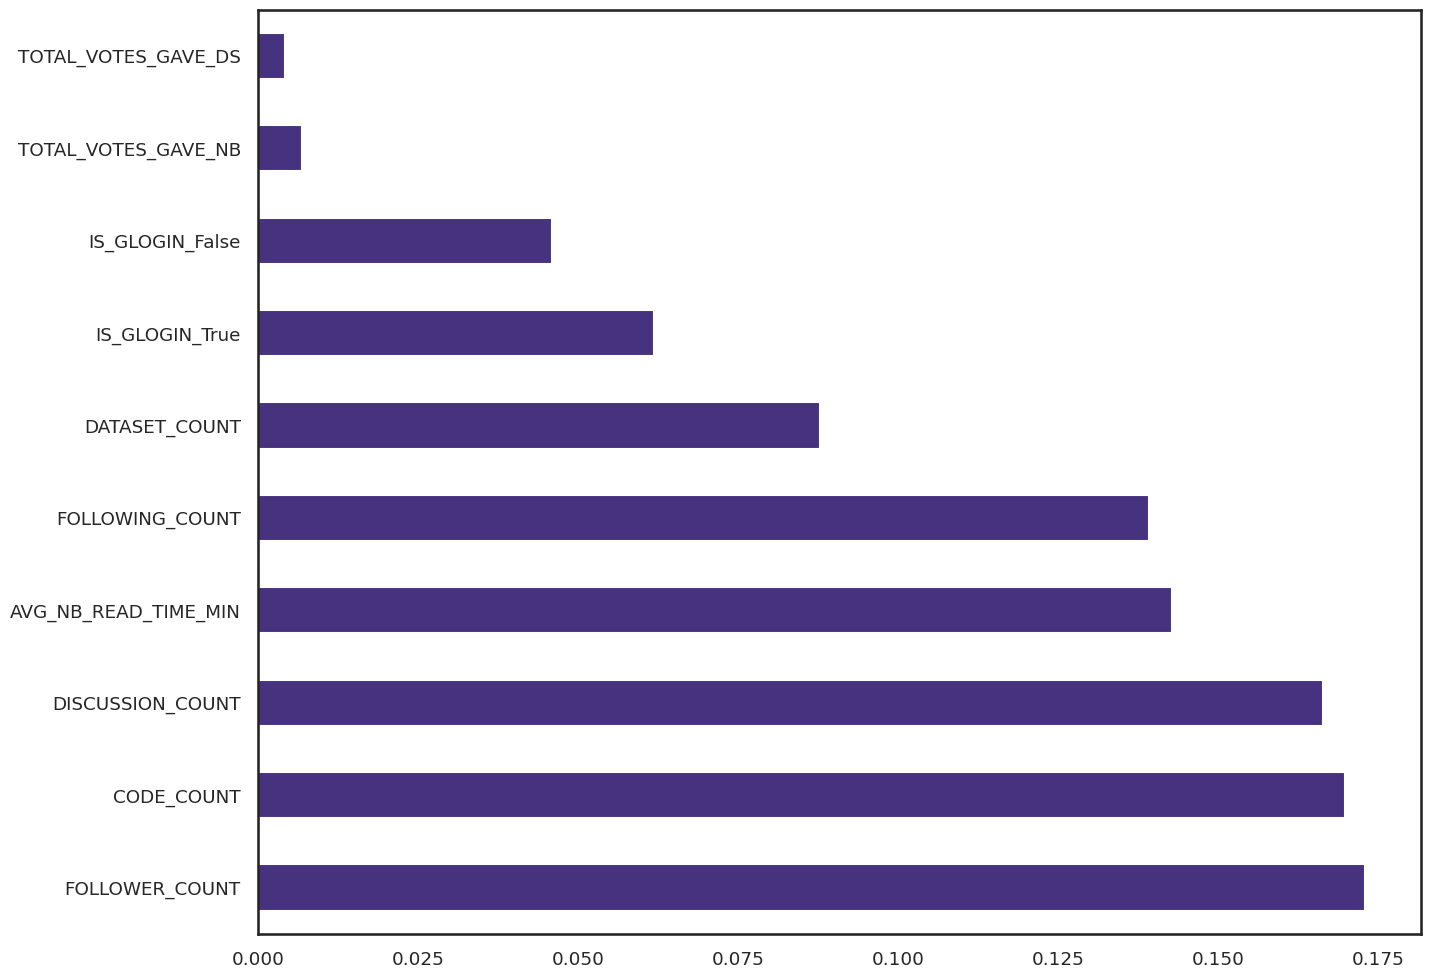

In [24]:
model = ExtraTreesClassifier()
model.fit(features,target)
print(model.feature_importances_)
feat_importance = pd.Series(model.feature_importances_,index=features.columns)
feat_importance.nlargest(10).plot(kind = 'barh')
plt.show()

## Performing cross validation on the dataset

In [25]:
# Define the LR model
logreg_model = LogisticRegression()

# Define the K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross validation and generate predictions
target_pred = cross_val_predict(logreg_model, features, target, cv=kfold)

# Generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [26]:
acc

0.9888763390148215

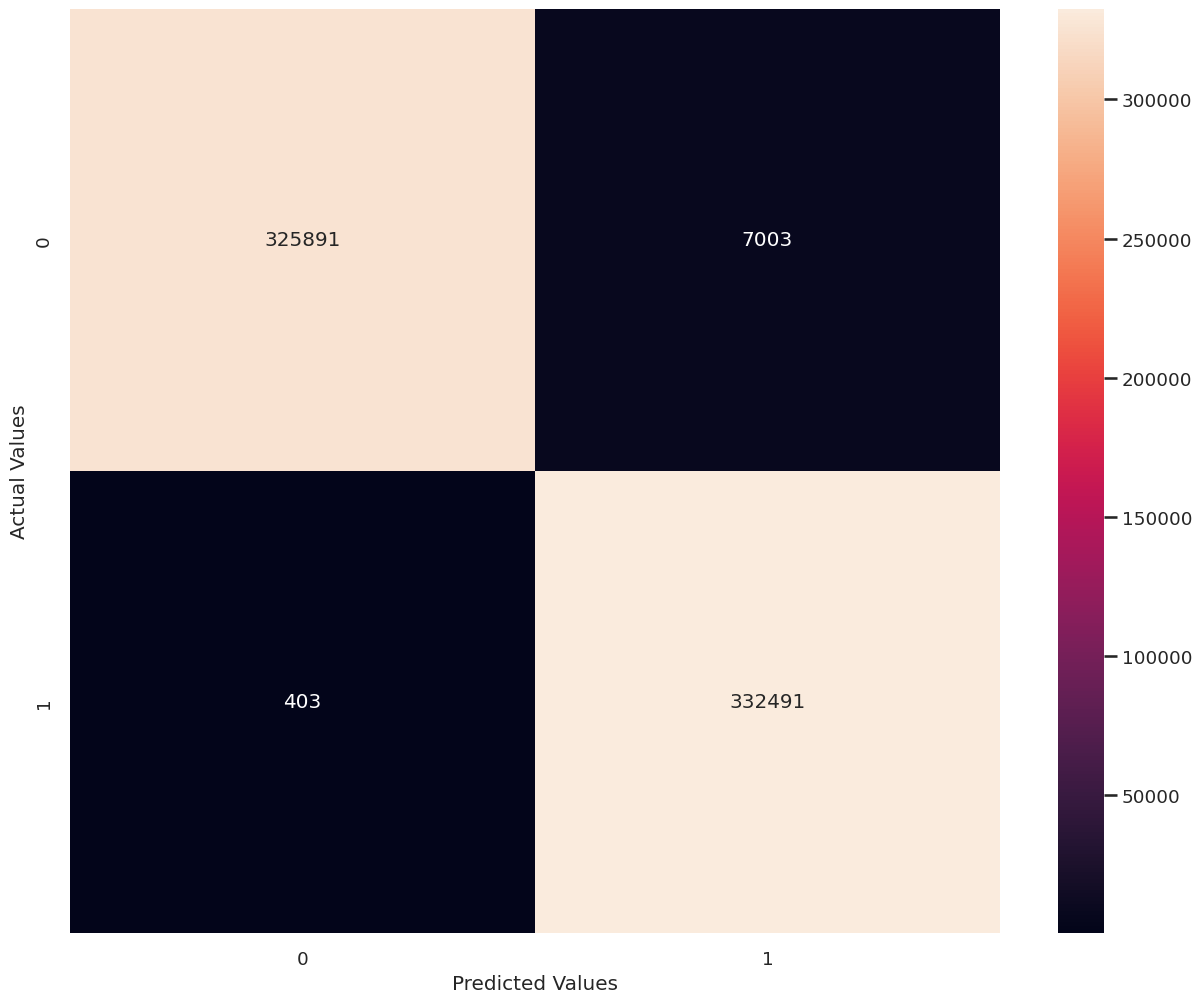

In [27]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [28]:
# Define the DT model
decision_tree_model = DecisionTreeClassifier()

# Define the K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross validation and generate predictions
target_pred = cross_val_predict(decision_tree_model, features, target, cv=kfold)

# Generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [29]:
acc

0.9745729871971258

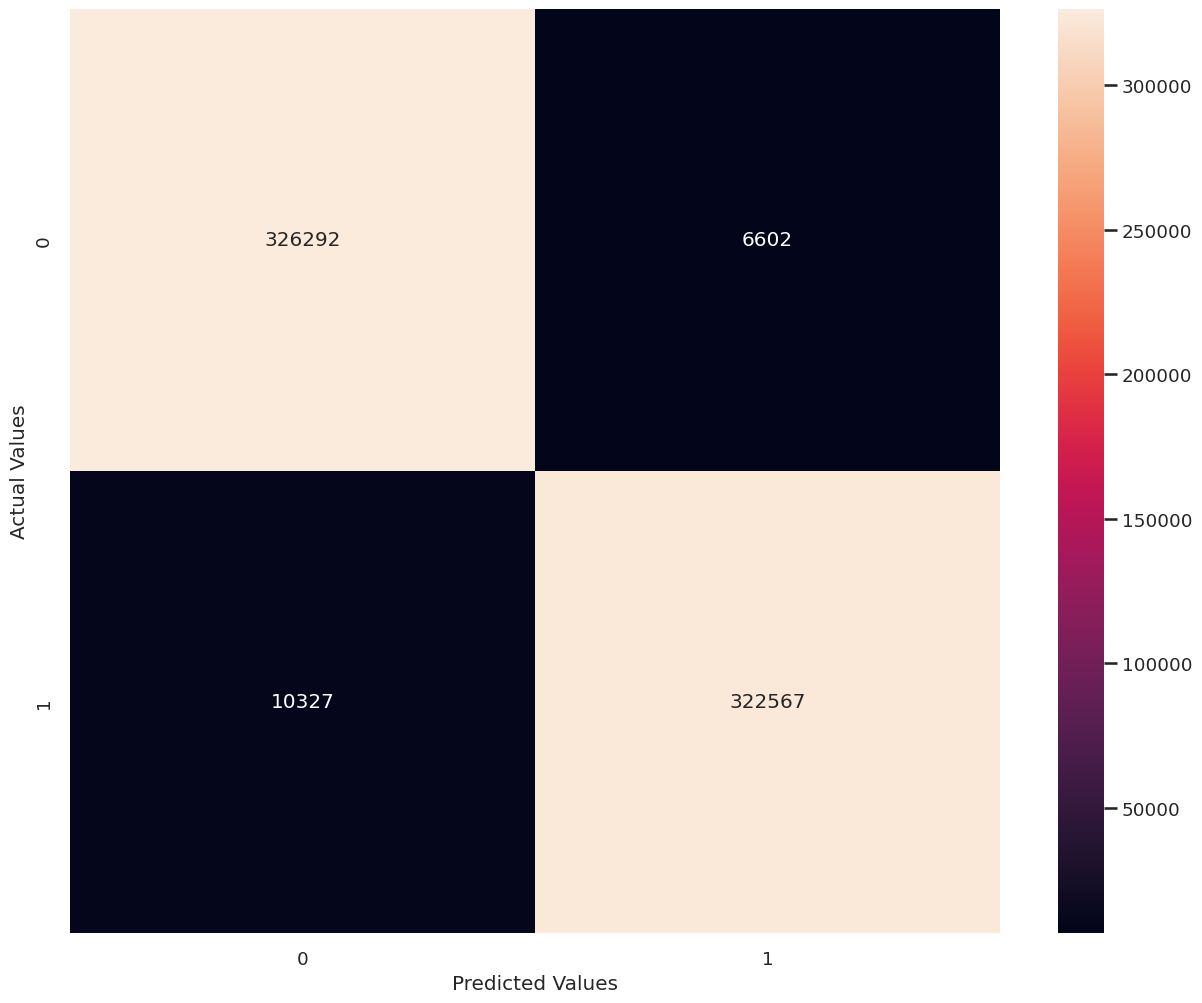

In [30]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [31]:
# Define the Gradient Boosting model
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# Define the K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross validation and generate predictions
target_pred = cross_val_predict(gradient_boosting_model, features, target, cv=kfold)

# Generate the confusion matrix and classification report
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [32]:
acc

0.9897129416571041

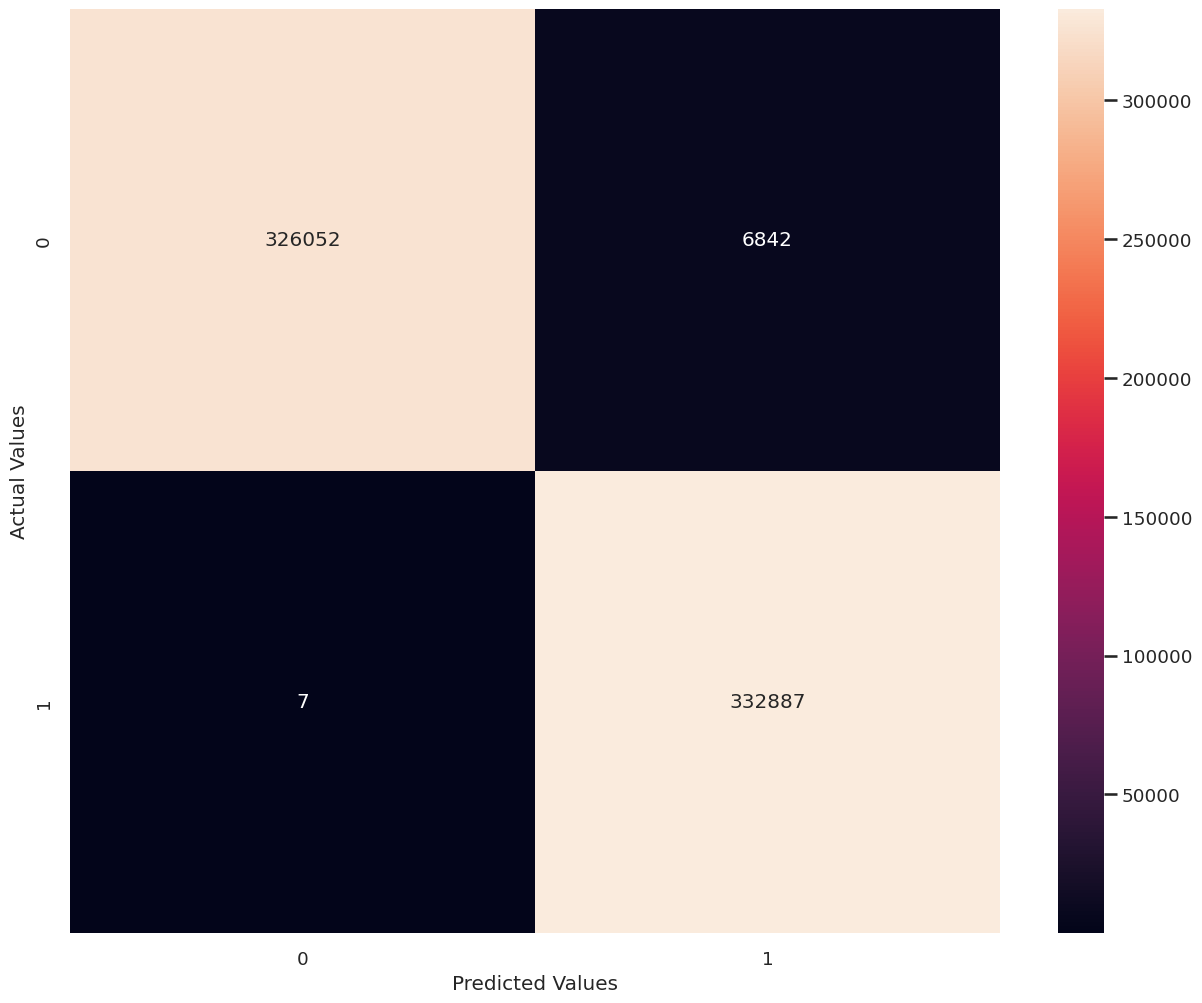

In [33]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [36]:
# Define the XGBClassifier model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit the model and perform cross validation
scores = cross_val_score(xgb_model, features, target, cv=kfold, scoring='accuracy')

# Train the model on the entire dataset for evaluation
xgb_model.fit(features, target)

# Generate predictions
target_pred = xgb_model.predict(features)

# Generate the confusion matrix, classification report, and accuracy
cm = confusion_matrix(target, target_pred)
cr = classification_report(target, target_pred)
acc = accuracy_score(target, target_pred)

In [37]:
acc

0.989724957493977

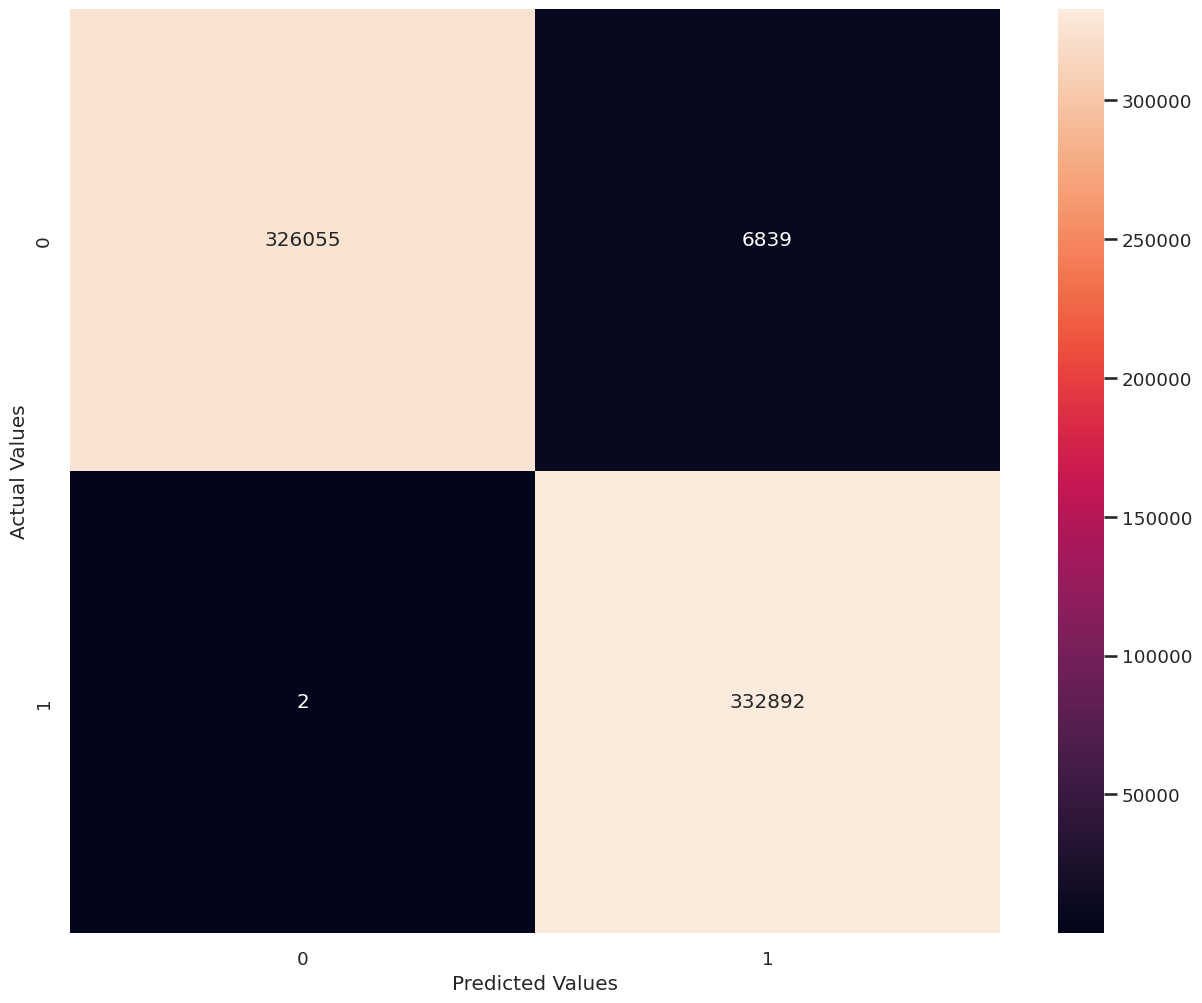

In [38]:
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()